## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Prepare Data

In [3]:
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms

def load_image_from_url_to_tensor(url):
    # 이미지 요청 및 로딩
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')  # RGB 변환

    # 변환 파이프라인 정의
    transform = transforms.Compose([
        transforms.Resize((299, 299)),           # (높이, 너비)
        transforms.ToTensor(),                   # [0, 1] 범위의 Tensor (C, H, W)
    ])

    # 이미지 변환 및 텐서 반환
    tensor = transform(image)
    tensor_shape = tensor.shape
    tensor = tensor.view(1, *tensor_shape) # Batch-wise shape
    return tensor

In [4]:
url = 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
images = load_image_from_url_to_tensor(url)
print(images.shape)  # torch.Size([3, 299, 299])

torch.Size([1, 3, 299, 299])


In [5]:
def imshow(img, title=None):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

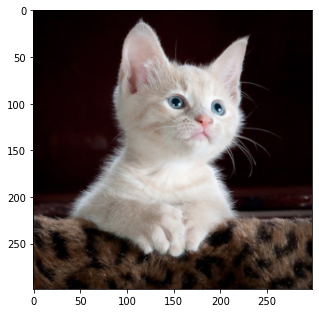

In [6]:
imshow(torchvision.utils.make_grid(images, normalize=True))

## 3. Download and Use Inception v3

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = models.inception_v3(pretrained=True).to(device)

In [9]:
model.eval()

images = images.to(device)
outputs = model(images)
_, pre = torch.max(outputs.data, 1)

print(pre)

tensor([283], device='cuda:0')


In [10]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [11]:
idx2label[283]

'Persian_cat'

In [12]:
true_labels = torch.tensor([283])

## 4. Adversarial Attack

### Untargeted Attack

In [13]:
def fgsm(model, loss, images, labels, eps, device):
    images = images.to(device)
    labels = labels.to(device)
    
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    adv_images = images + eps*images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)
    
    return adv_images

In [14]:
loss = nn.CrossEntropyLoss()
eps = 8/255

adv_images = fgsm(model, loss, images, true_labels, 
                  eps=eps, device=device)
outputs = model(adv_images)
_, pre = torch.max(outputs.data, 1)

print(pre)

tensor([285], device='cuda:0')


In [15]:
idx2label[285]

'Egyptian_cat'

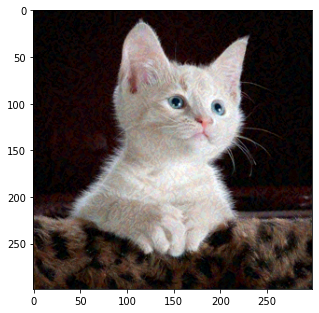

In [16]:
imshow(torchvision.utils.make_grid(adv_images.cpu(), normalize=True))

In [17]:
def pgd(model, loss, images, labels, eps, steps, alpha, device):
    images = images.to(device)
    labels = labels.to(device)
    
    adv_images = images.detach().clone()
    
    for _ in range(steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()
        
        adv_images = adv_images + alpha*adv_images.grad.sign()
        delta = (adv_images - images).detach().clone()
        adv_images = (images + torch.clamp(delta, -eps, eps)).detach().clone()

    return adv_images

In [18]:
loss = nn.CrossEntropyLoss()
eps = 8/255
steps = 10
alpha = 2/255

adv_images = pgd(model, loss, images, true_labels,
                 eps=eps, steps=steps, alpha=alpha, device=device)
outputs = model(adv_images)
_, pre = torch.max(outputs.data, 1)

print(pre)

tensor([285], device='cuda:0')


In [26]:
idx2label[285]

'Egyptian_cat'

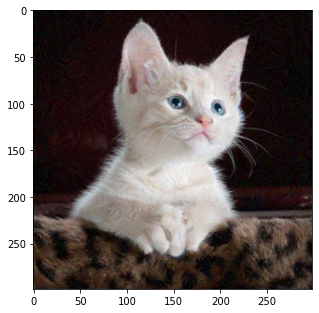

In [20]:
imshow(torchvision.utils.make_grid(adv_images.cpu(), normalize=True))

### Targeted Attack

In [21]:
idx2label[100]

'black_swan'

In [22]:
def pgd_targeted(model, loss, images, target_labels, eps, steps, alpha, device):
    images = images.to(device)
    target_labels = target_labels.to(device)
    
    adv_images = images.detach().clone()
    
    for _ in range(steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, target_labels).to(device)
        cost.backward()
        
        adv_images = adv_images - alpha*adv_images.grad.sign()
        delta = (adv_images - images).detach().clone()
        adv_images = (images + torch.clamp(delta, -eps, eps)).detach().clone()

    return adv_images

In [23]:
target_labels = torch.tensor([100])

loss = nn.CrossEntropyLoss()
eps = 8/255
steps = 10
alpha = 2/255

adv_images = pgd_targeted(model, loss, images, target_labels,
                          eps=eps, steps=steps, alpha=alpha, device=device)
outputs = model(adv_images)
_, pre = torch.max(outputs.data, 1)

print(pre)

tensor([100], device='cuda:0')


In [24]:
idx2label[100]

'black_swan'

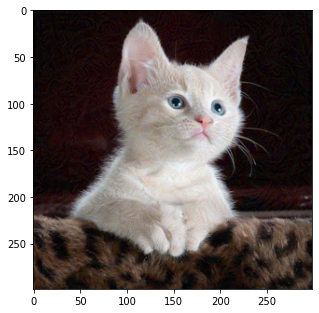

In [25]:
imshow(torchvision.utils.make_grid(adv_images.cpu(), normalize=True))